In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import warnings
warnings.filterwarnings('ignore')

API_KEY = 'RIWOMQAIJJ40V284'

plt.style.use('seaborn')

In [5]:
def draw_candle(candle):
    x = candle.index[0]
    o = candle.values[0][0]
    h = candle.values[0][1]
    l = candle.values[0][2]
    c = candle.values[0][3]
    color = 'green' if o <= c else 'red'
    plt.plot([x, x], [h, l], color=color, linewidth=1)
    plt.plot([x, x], [o, c], color=color, linewidth=4)
    plt.xticks(rotation='vertical')

def draw_hist(candle):
    x = candle.index[0]
    h = candle.values[0][9]
    color = '#88ff88' if h >= 0 else '#ff8888'
    plt.plot([x, x], [0, h], color=color, linewidth=4)
    plt.xticks(rotation='vertical')

In [6]:
sym = 'SBER'
http = urllib3.PoolManager()
r = http.request('GET',
                 'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords=' + sym + '&apikey=' + API_KEY)
df = pd.DataFrame.from_dict(json.loads(r.data)['bestMatches'])
df

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SBRCY,Sberbank of Russia,Equity,United States,09:30,16:00,UTC-05,USD,0.7273
1,SBER.MOS,Sberbank of Russia,Equity,Moscow,10:00,18:45,UTC+03,RUB,0.7273
2,SBNC.FRK,Sberbank of Russia,Equity,Frankfurt,08:00,20:00,UTC+01,EUR,0.6667
3,SBER.ILN,SBERBANK OF RUSSIA ADR (EACH RE,Equity,United Kingdom,08:00,16:30,UTC+00,GBP,0.6667
4,SBNC.DEX,Sberbank of Russia,Equity,XETRA,08:00,20:00,UTC+01,EUR,0.5455
5,RU000A0ERGA7.MOS,Sberbank Asset Management - Commercial Real Es...,Mutual Fund,Moscow,10:00,18:45,UTC+03,RUB,0.4000
6,SBERP.MOS,Sberbank of Russia,Equity,Moscow,10:00,18:45,UTC+03,RUB,0.2105


In [7]:
sym = 'SBER.MOS'
http = urllib3.PoolManager()
r = http.request('GET', 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + sym +
                 '&outputsize=full&apikey=' + API_KEY)

In [8]:
data = pd.DataFrame.from_dict(json.loads(r.data)['Time Series (Daily)'], orient='index', dtype=float)
data.rename(lambda x: x.split('. ')[1], axis='columns', inplace=True)

In [9]:
data['fast'] = data.close.ewm(span=12).mean()
data['slow'] = data.close.ewm(span=26).mean()
data['macd'] = data.fast - data.slow
data['signal'] = data.macd.ewm(span=9).mean()
data['hist'] = data.macd - data.signal

In [10]:
data.head()

,open,high,low,close,volume,fast,slow,macd,signal,hist
2011-11-21,79.00,79.37,75.85,75.99,293803296.0,75.990000,75.990000,0.000000,0.000000,0.000000
2011-11-22,76.94,77.76,75.10,76.40,272599360.0,76.212083,76.202885,0.009199,0.005110,0.004088
2011-11-23,75.00,77.44,74.42,76.80,335403040.0,76.441547,76.417422,0.024125,0.012903,0.011222
2011-11-24,76.73,77.29,73.82,73.82,177337888.0,75.614027,75.691297,-0.077269,-0.017643,-0.059626
2011-11-25,75.40,78.75,73.75,78.27,319155936.0,76.335646,76.289309,0.046337,0.001390,0.044947


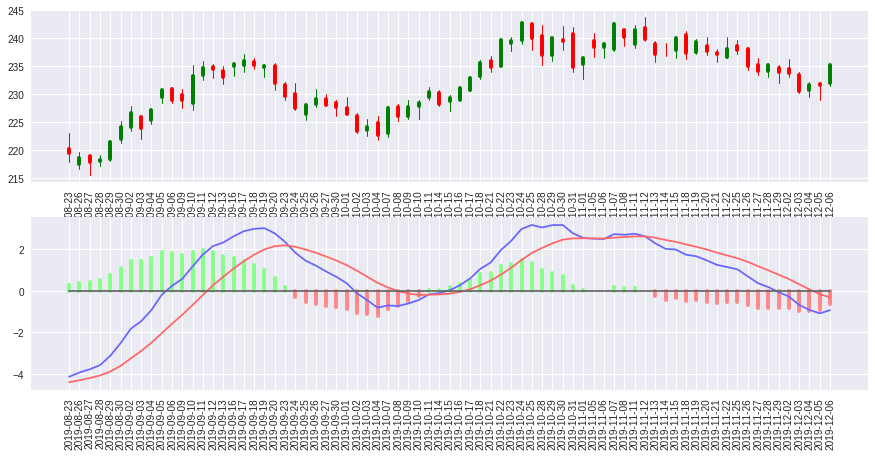

In [11]:
start, end = data.shape[0]-75, data.shape[0]

fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
for i in range(start, end):
    draw_candle(data[i:i+1])

plt.subplot(2, 1, 2)
for i in range(start, end):
    draw_hist(data[i:i+1])
plt.plot(data.index[start:end], data.macd[start:end], color='#6666ff')
plt.plot(data.index[start:end], data.signal[start:end], color='#ff6666') 
plt.plot(data.index[start:end], np.zeros(end-start), color='#666666')


In [12]:
%%time
data['type'] = ''
for i in range(2, data.shape[0]):
    if data['hist'][i-1] > 0 and data['hist'][i-2] < 0:
        data['type'][i] = 'long'
    if data['hist'][i-1] < 0 and data['hist'][i-2] > 0:
        data['type'][i] = 'short'

CPU times: user 6.66 s, sys: 100 ms, total: 6.76 s
Wall time: 7.01 s


In [13]:
deals = data[data['type'] != '']
deals['dif'] = 0
deals['profit'] = 0

In [14]:
deals['dif'] = deals['open'].rolling(window=2).apply(lambda x: x[1] - x[0])
deals.loc[deals['type'] == 'long', 'dif'] = -deals['dif']

In [15]:
deals['profit'] = deals['dif'] * 50

In [16]:
deals.head(10)

,open,high,low,close,volume,fast,slow,macd,signal,hist,type,dif,profit
2011-11-25,75.40,78.750,73.7500,78.27,319155936.0,76.335646,76.289309,0.046337,0.001390,0.044947,short,NaN,NaN
2011-11-28,80.00,83.070,79.5200,83.00,320434016.0,77.955434,77.633407,0.322028,0.088300,0.233727,long,-4.60,-230.0
2011-12-12,83.51,84.800,79.1700,79.90,267378544.0,83.897570,83.441230,0.456340,0.874519,-0.418179,short,3.51,175.5
2012-01-12,85.11,86.380,84.3000,84.30,279302848.0,58.519432,63.977173,-5.457741,-8.081876,2.624136,long,-1.60,-80.0
2012-02-16,95.98,111.803,50.5544,96.24,291937.0,94.128330,88.626058,5.502273,5.744842,-0.242569,short,10.87,543.5
2012-03-23,95.51,97.600,48.5300,96.73,221690715.0,91.121052,90.807459,0.313593,-0.278544,0.592137,long,0.47,23.5
2012-04-12,96.40,96.740,94.6000,95.50,141555250.0,95.670170,94.418183,1.251987,1.369961,-0.117973,short,0.89,44.5
2012-06-01,81.60,82.150,77.9500,78.80,195306920.0,82.106365,85.080998,-2.974633,-2.962160,-0.012473,long,14.80,740.0
2012-06-04,77.49,78.870,76.2500,77.70,16345472.0,81.428463,84.534238,-3.105775,-2.990883,-0.114892,short,-4.11,-205.5
2012-06-07,81.10,83.750,79.9100,81.94,21083224.0,81.030079,83.662221,-2.632142,-2.929495,0.297353,long,-3.61,-180.5


In [17]:
deals['profit'].sum()

8545.000000000007

In [18]:
deals['profit'].cumsum()

2011-11-25       NaN
2011-11-28    -230.0
2011-12-12     -54.5
2012-01-12    -134.5
2012-02-16     409.0
2012-03-23     432.5
2012-04-12     477.0
2012-06-01    1217.0
2012-06-04    1011.5
2012-06-07     831.0
2012-07-24    1126.0
2012-08-07     826.5
2012-08-20     789.0
2012-09-18     650.5
2012-09-20     557.5
2012-10-18     553.5
2012-10-30     457.0
2012-11-23     608.0
2012-12-25     832.0
2013-01-09     550.0
2013-02-08     929.5
2013-04-05    1266.0
2013-04-16    1104.5
2013-04-25    1003.5
2013-04-30     875.0
2013-05-02     746.5
2013-05-28    1004.5
2013-07-01    1473.5
2013-07-29    1521.0
2013-08-14    1385.0
               ...  
2018-02-19    2162.0
2018-03-05    2497.0
2018-04-25    5174.5
2018-05-25    5292.5
2018-06-25    6193.0
2018-06-26    6150.0
2018-06-29    5827.0
2018-07-20    5710.5
2018-09-04    6999.0
2018-09-11    6460.5
2018-09-14    5772.0
2018-10-08    5872.0
2018-11-02    5722.5
2018-11-27    5722.0
2018-12-05    5436.0
2018-12-06    5351.0
2019-01-08   

# Monthly SBER statistics

In [26]:
sym = 'SBER'
http = urllib3.PoolManager()
r = http.request('GET',
                 'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords=' + sym + '&apikey=' + API_KEY)
df = pd.DataFrame.from_dict(json.loads(r.data)['bestMatches'])
df

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SBRCY,Sberbank of Russia,Equity,United States,09:30,16:00,UTC-05,USD,0.7273
1,SBER.MOS,Sberbank of Russia,Equity,Moscow,10:00,18:45,UTC+03,RUB,0.7273
2,SBERP.MOS,Sberbank of Russia,Equity,Moscow,10:00,18:45,UTC+03,RUB,0.6667
3,SBER.ILN,SBERBANK OF RUSSIA ADR (EACH RE,Equity,United Kingdom,08:00,16:30,UTC+00,GBP,0.6667
4,SBNC.FRK,Sberbank of Russia,Equity,Frankfurt,08:00,20:00,UTC+01,EUR,0.5455
5,SBNC.DEX,Sberbank of Russia,Equity,XETRA,08:00,20:00,UTC+01,EUR,0.4000
6,RU000A0ERGA7.MOS,Sberbank Asset Management - Commercial Real Es...,Mutual Fund,Moscow,10:00,18:45,UTC+03,RUB,0.2857
7,RU000A0ZZ5R2.MOS,PIF SberbankArendBiznes3,Mutual Fund,Moscow,10:00,18:45,UTC+03,RUB,0.2105


In [4]:
sym = 'SBER.MOS'
http = urllib3.PoolManager()
r = http.request('GET', 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol=' + sym +
                 '&outputsize=full&apikey=' + API_KEY)

In [7]:
data = pd.DataFrame.from_dict(json.loads(r.data)['Monthly Time Series'], orient='index', dtype=float)
data.rename(lambda x: x.split('. ')[1], axis='columns', inplace=True)

In [20]:
data['lead'] = 0
data['lead'][1:] = data.close[:-1]
x = (data.close[1:] - data.lead[1:]).values

In [21]:
x

array([ 10.77,   9.62,  -4.65,  -1.36, -12.28,   4.9 ,   3.33,   3.47,
        -2.21,   0.8 ,  -0.38,   1.53,  16.65,  -5.02,  -5.71,   0.25,
        -0.06,  -5.37,   1.55,  -7.  ,   9.47,   5.1 ,   0.47,  -2.22,
        -6.25,  -3.7 ,  -7.3 , -11.3 ,  12.  ,   0.  , -10.9 ,  -0.39,
         2.31,   0.71,  -3.98, -17.35,   6.6 ,  14.41, -13.03,  14.02,
        -3.4 ,  -1.15,  -0.05,   2.2 ,   0.8 ,  15.23,  12.37,  -1.64,
        -4.76,  10.5 ,   2.9 ,  13.65,   9.01,   0.44,   6.15,   4.35,
         1.84,   2.06,  11.3 ,  14.55,  -1.05, -16.2 ,   3.8 ,   5.4 ,
        -9.27, -10.34,  18.94,  18.98,   8.82,   1.47,  30.55,   0.85,
        39.3 ,   7.9 , -18.83, -26.58,  -4.63,  -4.36,  -3.14, -32.86,
        21.32, -13.52,   4.2 ,  -7.5 ,  31.4 , -10.1 ,   7.12,  10.25,
         8.07,   5.31,  -5.06,  -9.29,   3.51,   7.18,   2.89])

In [25]:
x.std()

11.064035873819938